<a href="https://colab.research.google.com/github/sk643666/AIFFEL_quest_cr/blob/master/test_src/YYY_0116.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymunk
!pip install ultralytics
!pip show pymunk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 23.9 MB/s eta 0:00:00
Name: pymunk
Version: 6.10.0
Summary: Pymunk is a easy-to-use pythonic 2D physics library
Home-page: https://www.pymunk.org
Author: 
Author-email: Victor Blomqvist <vb@viblo.se>
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: cffi
Required-by: 



0: 736x1280 1 frame, 1 red ball, 1 table, 1 white ball, 1 yellow ball, 30.2ms
Speed: 9.9ms preprocess, 30.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


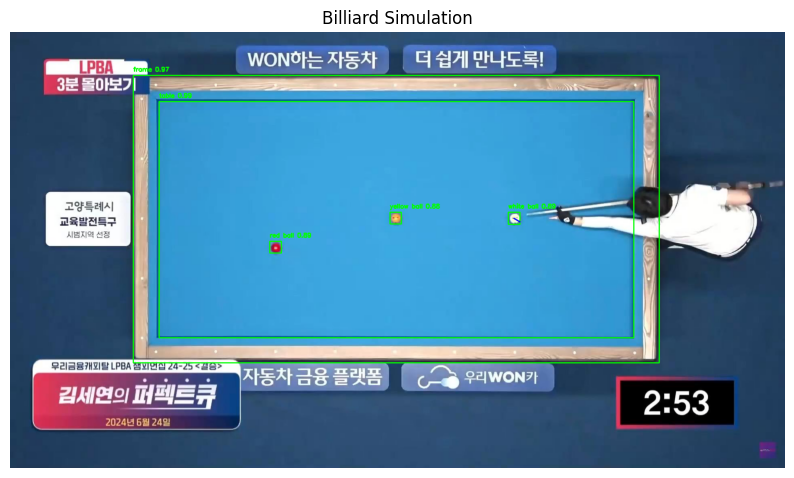

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import cv2
import torch

# 1) YOLO 모델 로드
model_path = "JJJ.pt"
model = YOLO(model_path)

# 2) 이미지 로드
image_path = "MMM.jpg"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

# 3) 모델 추론
results = model.predict(source=image, conf=0.5)

# 4) 당구대, 공, 프레임 등 저장할 구조
objects = []
table = None

# 클래스 ID 매핑
class_map = {
    0: "blue ball",
    1: "frame",
    2: "red ball",
    3: "table",
    4: "white ball",
    5: "yellow ball"
}

# 5) 바운딩 박스 처리
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        conf = box.conf[0]
        cls_id = int(box.cls[0])

        ix1, iy1, ix2, iy2 = map(int, [x1, y1, x2, y2])
        cls_name = class_map.get(cls_id, f"Unknown({cls_id})")

        # OpenCV로 바운딩 박스 시각화
        cv2.rectangle(image, (ix1, iy1), (ix2, iy2), (0, 255, 0), 2)
        label = f"{cls_name} {conf:.2f}"
        cv2.putText(image, label, (ix1, max(iy1 - 10, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # 테이블과 다른 객체 분류
        if cls_id == 3:  # 테이블
            table = {
                "cls_name": "table",
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            }
        else:
            objects.append({
                "cls_name": cls_name,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "confidence": conf
            })

# 테이블 기본값 설정
if table is None:
    table = {
        "cls_name": "table(default)",
        "x1": 0, "y1": 0, "x2": 1280, "y2": 720,
        "confidence": 1.0
    }

# 공 위치 계산
def get_ball_center(obj):
    x_center = (obj["x1"] + obj["x2"]) / 2
    y_center = (obj["y1"] + obj["y2"]) / 2
    # 텐서인 경우 CPU로 변환 후 반환
    if isinstance(x_center, torch.Tensor):
        x_center = x_center.cpu().numpy()
    if isinstance(y_center, torch.Tensor):
        y_center = y_center.cpu().numpy()
    return x_center, y_center

# 경로 시뮬레이션
def simulate_path(start, direction, table, num_bounces=3):
    path = [start]
    for _ in range(num_bounces):
        next_point = np.array(path[-1]) + direction

        # 테이블 경계와 충돌 여부 확인
        if next_point[0] <= table["x1"] or next_point[0] >= table["x2"]:
            direction[0] *= -1  # x축 반사
        if next_point[1] <= table["y1"] or next_point[1] >= table["y2"]:
            direction[1] *= -1  # y축 반사

        path.append(np.array(path[-1]) + direction)
    return path

# 시작 위치와 초기 방향 설정
white_ball = next((obj for obj in objects if obj["cls_name"] == "white ball"), None)
if white_ball:
    start = np.array(get_ball_center(white_ball))
    direction = np.array([5, 3])  # 초기 속도 (예시)

    # 경로 계산
    path = simulate_path(start, direction, table, num_bounces=3)

    # 목표 공과 충돌 확인
    for obj in objects:
        if obj["cls_name"] != "white ball":
            target_center = get_ball_center(obj)
            for point in path:
                if np.linalg.norm(np.array(point) - np.array(target_center)) < 10:  # 임계값
                    print(f"충돌 예측: {obj['cls_name']} at {target_center}")

    # 경로 시각화
    for i in range(1, len(path)):
        cv2.line(image, tuple(map(int, path[i - 1])), tuple(map(int, path[i])), (255, 0, 0), 2)

# 시각화
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Billiard Simulation")
plt.show()


[Collision] type1 <-> type3, velA=Vec2d(-0.06112091745242276, -5.468384251749095e-05), velB=Vec2d(-0.5822571609941332, -0.0005209355526526048)
[Collision] type1 <-> type3, velA=Vec2d(0.25468225518297244, 0.021664600557204913), velB=Vec2d(-0.004719674608344826, -0.021909367192996815)


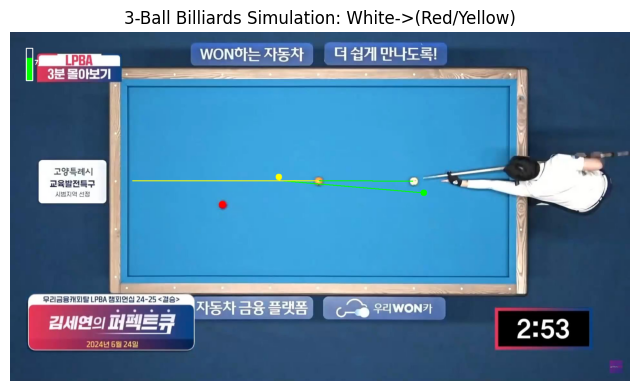

In [13]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt


def to_cpu_float(value):
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
red_ball = next(obj for obj in objects if obj["cls_name"] == "red ball")
yellow_ball = next(obj for obj in objects if obj["cls_name"] == "yellow ball")

wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])
rx1, ry1 = to_cpu_float(red_ball["x1"]), to_cpu_float(red_ball["y1"])
rx2, ry2 = to_cpu_float(red_ball["x2"]), to_cpu_float(red_ball["y2"])
yx1, yy1 = to_cpu_float(yellow_ball["x1"]), to_cpu_float(yellow_ball["y1"])
yx2, yy2 = to_cpu_float(yellow_ball["x2"]), to_cpu_float(yellow_ball["y2"])

white_pos_px = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
red_pos_px = np.array([(rx1 + rx2) / 2.0, (ry1 + ry2) / 2.0])
yellow_pos_px = np.array([(yx1 + yx2) / 2.0, (yy1 + yy2) / 2.0])

table_min_x = to_cpu_float(table["x1"])
table_min_y = to_cpu_float(table["y1"])
table_max_x = to_cpu_float(table["x2"])
table_max_y = to_cpu_float(table["y2"])

PIXELS_TO_METERS = 100.0
white_pos_world = (white_pos_px / PIXELS_TO_METERS).tolist()
red_pos_world = (red_pos_px / PIXELS_TO_METERS).tolist()
yellow_pos_world = (yellow_pos_px / PIXELS_TO_METERS).tolist()

table_min_x_world = table_min_x / PIXELS_TO_METERS
table_min_y_world = table_min_y / PIXELS_TO_METERS
table_max_x_world = table_max_x / PIXELS_TO_METERS
table_max_y_world = table_max_y / PIXELS_TO_METERS

space = pymunk.Space()
space.gravity = (0, 0)

mass = 1.0
radius = 0.05
moment = pymunk.moment_for_circle(mass, 0, radius)

left = table_min_x_world + radius
right = table_max_x_world - radius
bottom = table_min_y_world + radius
top = table_max_y_world - radius

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top), (right, top), cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top), cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom), (right, top), cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.9
    c.friction = 0.01
    space.add(c)

white_body = pymunk.Body(mass, moment)
white_body.position = white_pos_world
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.9
white_shape.friction = 0.05
white_shape.collision_type = 1
space.add(white_body, white_shape)

red_body = pymunk.Body(mass, moment)
red_body.position = red_pos_world
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.9
red_shape.friction = 0.05
red_shape.collision_type = 2
space.add(red_body, red_shape)

yellow_body = pymunk.Body(mass, moment)
yellow_body.position = yellow_pos_world
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.9
yellow_shape.friction = 0.05
yellow_shape.collision_type = 3
space.add(yellow_body, yellow_shape)

def collision_post_solve(arbiter, space, data):
    sA, sB = arbiter.shapes
    print(f"[Collision] type{sA.collision_type} <-> type{sB.collision_type}, velA={sA.body.velocity}, velB={sB.body.velocity}")
    return True

for ctypeA, ctypeB in [(1, 2), (1, 3), (2, 3)]:
    handler = space.add_collision_handler(ctypeA, ctypeB)
    handler.post_solve = collision_post_solve

strength_gauge = 7
max_speed = 1.0
initial_speed = (strength_gauge / 10.0) * max_speed
direction_vec = (yellow_body.position - white_body.position)
distance = direction_vec.length
direction_unit = direction_vec.normalized() if distance > 0 else Vec2d(1, 0)
white_body.velocity = direction_unit * initial_speed

dt = 1 / 60.0
max_steps = 3000
stop_threshold = 0.02

positions_white = []
positions_red = []
positions_yellow = []

collision_count = 0

for step in range(max_steps):
    space.step(dt)

    white_body.velocity *= (1 - 0.02 * dt)
    red_body.velocity *= (1 - 0.02 * dt)
    yellow_body.velocity *= (1 - 0.02 * dt)

    if white_body.velocity.length < stop_threshold:
        white_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < stop_threshold:
        red_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < stop_threshold:
        yellow_body.velocity = Vec2d(0, 0)

    positions_white.append((white_body.position.x, white_body.position.y))
    positions_red.append((red_body.position.x, red_body.position.y))
    positions_yellow.append((yellow_body.position.x, yellow_body.position.y))

    for cushion in cushions:
      query_info = cushion.segment_query(
        white_body.position,
        white_body.position + white_body.velocity.normalized()
      )
    # Check if the segment query detected a collision
      if query_info.shape is not None and query_info.alpha < 1.0:
        collision_count += 1
        if collision_count == 3:
            white_body.velocity = Vec2d(0, 0)
            break


    if collision_count == 3:
        break

final_wpos = white_body.position * PIXELS_TO_METERS
final_rpos = red_body.position * PIXELS_TO_METERS
final_ypos = yellow_body.position * PIXELS_TO_METERS

image = cv2.imread(image_path)

def draw_trajectory(img, positions, color_bgr, px_to_m=PIXELS_TO_METERS):
    for i in range(len(positions) - 1):
        x1, y1 = positions[i]
        x2, y2 = positions[i + 1]
        cv2.line(img, (int(x1 * px_to_m), int(y1 * px_to_m)), (int(x2 * px_to_m), int(y2 * px_to_m)), color_bgr, 2)

draw_trajectory(image, positions_white, (0, 255, 0))
draw_trajectory(image, positions_red, (0, 0, 255))
draw_trajectory(image, positions_yellow, (0, 255, 255))

cv2.circle(image, (int(final_wpos.x), int(final_wpos.y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(final_rpos.x), int(final_rpos.y)), 10, (0, 0, 255), -1)
cv2.circle(image, (int(final_ypos.x), int(final_ypos.y)), 10, (0, 255, 255), -1)

gauge_max_height = 100
gauge_height = int((strength_gauge / 10) * gauge_max_height)
gauge_x, gauge_y = 50, 50
gauge_width = 20

cv2.rectangle(image, (gauge_x, gauge_y + gauge_max_height - gauge_height), (gauge_x + gauge_width, gauge_y + gauge_max_height), (0, 255, 0), -1)
cv2.rectangle(image, (gauge_x, gauge_y), (gauge_x + gauge_width, gauge_y + gauge_max_height), (255, 255, 255), 2)
cv2.putText(image, f"{strength_gauge}/10", (gauge_x + gauge_width + 5, gauge_y + gauge_max_height // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("3-Ball Billiards Simulation: White->(Red/Yellow)")
plt.show()


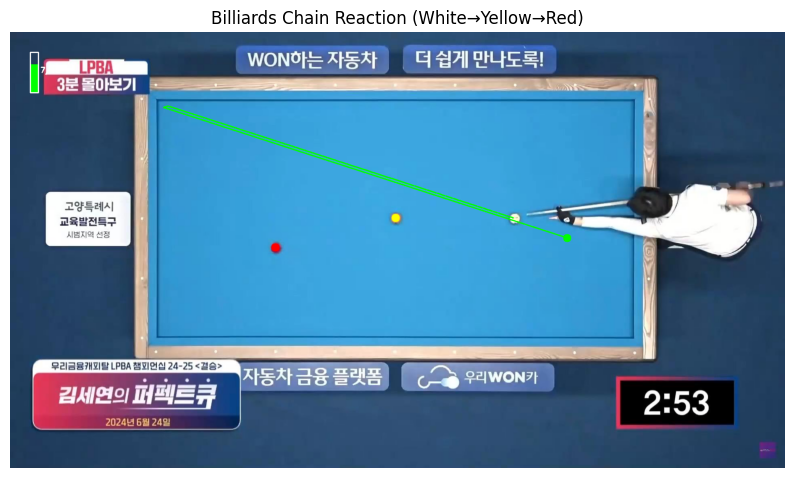

In [14]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

def to_cpu_float(value):
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
red_ball = next(obj for obj in objects if obj["cls_name"] == "red ball")
yellow_ball = next(obj for obj in objects if obj["cls_name"] == "yellow ball")

wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])

rx1, ry1 = to_cpu_float(red_ball["x1"]), to_cpu_float(red_ball["y1"])
rx2, ry2 = to_cpu_float(red_ball["x2"]), to_cpu_float(red_ball["y2"])

yx1, yy1 = to_cpu_float(yellow_ball["x1"]), to_cpu_float(yellow_ball["y1"])
yx2, yy2 = to_cpu_float(yellow_ball["x2"]), to_cpu_float(yellow_ball["y2"])

white_pos_px = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
red_pos_px = np.array([(rx1 + rx2) / 2.0, (ry1 + ry2) / 2.0])
yellow_pos_px = np.array([(yx1 + yx2) / 2.0, (yy1 + yy2) / 2.0])

table_min_x = to_cpu_float(table["x1"])
table_min_y = to_cpu_float(table["y1"])
table_max_x = to_cpu_float(table["x2"])
table_max_y = to_cpu_float(table["y2"])

PIXELS_TO_METERS = 100.0

white_pos_world = (white_pos_px / PIXELS_TO_METERS).tolist()
red_pos_world = (red_pos_px / PIXELS_TO_METERS).tolist()
yellow_pos_world = (yellow_pos_px / PIXELS_TO_METERS).tolist()

table_min_x_world = table_min_x / PIXELS_TO_METERS
table_min_y_world = table_min_y / PIXELS_TO_METERS
table_max_x_world = table_max_x / PIXELS_TO_METERS
table_max_y_world = table_max_y / PIXELS_TO_METERS

space = pymunk.Space()
space.gravity = (0, 0)

mass = 1.0
radius = 0.05
moment = pymunk.moment_for_circle(mass, 0, radius)

left = table_min_x_world + radius
right = table_max_x_world - radius
bottom = table_min_y_world + radius
top = table_max_y_world - radius

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top), (right, top), cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top), cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom), (right, top), cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.9
    c.friction = 0.01
    space.add(c)

white_body = pymunk.Body(mass, moment)
white_body.position = white_pos_world
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.9
white_shape.friction = 0.05
white_shape.collision_type = 1
space.add(white_body, white_shape)

red_body = pymunk.Body(mass, moment)
red_body.position = red_pos_world
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.9
red_shape.friction = 0.05
red_shape.collision_type = 2
space.add(red_body, red_shape)

yellow_body = pymunk.Body(mass, moment)
yellow_body.position = yellow_pos_world
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.9
yellow_shape.friction = 0.05
yellow_shape.collision_type = 3
space.add(yellow_body, yellow_shape)

def collision_post_solve(arbiter, space, data):
    sA, sB = arbiter.shapes
    return True

for ctypeA, ctypeB in [(1, 2), (1, 3), (2, 3)]:
    handler = space.add_collision_handler(ctypeA, ctypeB)
    handler.post_solve = collision_post_solve

strength_gauge = 7
max_speed = 1.0
initial_speed = (strength_gauge / 10) * max_speed

direction_vec = cushions[2].a - white_body.position
if direction_vec.length > 0:
    direction_unit = direction_vec.normalized()
else:
    direction_unit = Vec2d(1, 0)

white_body.velocity = direction_unit * initial_speed

dt = 1 / 60.0
max_steps = 3000
stop_threshold = 0.02

positions_white = []
positions_red = []
positions_yellow = []

global_friction_coef = 0.02

for step in range(max_steps):
    space.step(dt)

    white_body.velocity *= (1 - global_friction_coef * dt)
    red_body.velocity *= (1 - global_friction_coef * dt)
    yellow_body.velocity *= (1 - global_friction_coef * dt)

    if white_body.velocity.length < stop_threshold:
        white_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < stop_threshold:
        red_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < stop_threshold:
        yellow_body.velocity = Vec2d(0, 0)

    positions_white.append((white_body.position.x, white_body.position.y))
    positions_red.append((red_body.position.x, red_body.position.y))
    positions_yellow.append((yellow_body.position.x, yellow_body.position.y))

    if (
        white_body.velocity.length == 0
        and red_body.velocity.length == 0
        and yellow_body.velocity.length == 0
    ):
        break

final_wpos = white_body.position * PIXELS_TO_METERS
final_rpos = red_body.position * PIXELS_TO_METERS
final_ypos = yellow_body.position * PIXELS_TO_METERS

image = cv2.imread(image_path)

def draw_trajectory(img, positions, color_bgr, px_to_m=PIXELS_TO_METERS):
    for i in range(len(positions) - 1):
        x1, y1 = positions[i]
        x2, y2 = positions[i + 1]
        p1 = (int(x1 * px_to_m), int(y1 * px_to_m))
        p2 = (int(x2 * px_to_m), int(y2 * px_to_m))
        cv2.line(img, p1, p2, color_bgr, 2)

draw_trajectory(image, positions_white, (0, 255, 0))
draw_trajectory(image, positions_red, (0, 0, 255))
draw_trajectory(image, positions_yellow, (0, 255, 255))

cv2.circle(image, (int(final_wpos.x), int(final_wpos.y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(final_rpos.x), int(final_rpos.y)), 10, (0, 0, 255), -1)
cv2.circle(image, (int(final_ypos.x), int(final_ypos.y)), 10, (0, 255, 255), -1)

gauge_max_height = 100
gauge_height = int((strength_gauge / 10) * gauge_max_height)
gauge_x, gauge_y = 50, 50
gauge_width = 20

cv2.rectangle(
    image,
    (gauge_x, gauge_y + gauge_max_height - gauge_height),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (0, 255, 0),
    -1,
)
cv2.rectangle(
    image,
    (gauge_x, gauge_y),
    (gauge_x + gauge_width, gauge_y + gauge_max_height),
    (255, 255, 255),
    2,
)
cv2.putText(
    image,
    f"{strength_gauge}/10",
    (gauge_x + gauge_width + 5, gauge_y + gauge_max_height // 2),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.6,
    (255, 255, 255),
    2,
)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Billiards Chain Reaction (White→Yellow→Red)")
plt.show()


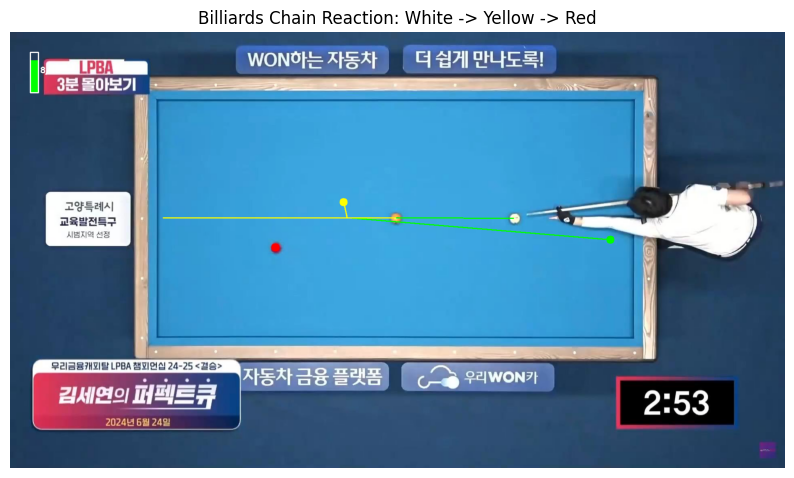

In [15]:
import pymunk
from pymunk import Vec2d
import numpy as np
import cv2
import matplotlib.pyplot as plt

def to_cpu_float(value):
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
yellow_ball = next(obj for obj in objects if obj["cls_name"] == "yellow ball")
red_ball = next(obj for obj in objects if obj["cls_name"] == "red ball")

wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])
yx1, yy1 = to_cpu_float(yellow_ball["x1"]), to_cpu_float(yellow_ball["y1"])
yx2, yy2 = to_cpu_float(yellow_ball["x2"]), to_cpu_float(yellow_ball["y2"])
rx1, ry1 = to_cpu_float(red_ball["x1"]), to_cpu_float(red_ball["y1"])
rx2, ry2 = to_cpu_float(red_ball["x2"]), to_cpu_float(red_ball["y2"])

white_center_px = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
yellow_center_px = np.array([(yx1 + yx2) / 2.0, (yy1 + yy2) / 2.0])
red_center_px = np.array([(rx1 + rx2) / 2.0, (ry1 + ry2) / 2.0])

table_min_x = to_cpu_float(table["x1"])
table_min_y = to_cpu_float(table["y1"])
table_max_x = to_cpu_float(table["x2"])
table_max_y = to_cpu_float(table["y2"])

PIXELS_TO_METERS = 100.0
white_pos_world = (white_center_px / PIXELS_TO_METERS).tolist()
yellow_pos_world = (yellow_center_px / PIXELS_TO_METERS).tolist()
red_pos_world = (red_center_px / PIXELS_TO_METERS).tolist()

table_min_x_world = table_min_x / PIXELS_TO_METERS
table_min_y_world = table_min_y / PIXELS_TO_METERS
table_max_x_world = table_max_x / PIXELS_TO_METERS
table_max_y_world = table_max_y / PIXELS_TO_METERS

space = pymunk.Space()
space.gravity = (0, 0)

mass = 1.0
radius = 0.05
moment = pymunk.moment_for_circle(mass, 0, radius)

left = table_min_x_world + radius
right = table_max_x_world - radius
bottom = table_min_y_world + radius
top = table_max_y_world - radius

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top), (right, top), cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top), cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom), (right, top), cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.9
    c.friction = 0.01
    space.add(c)

white_body = pymunk.Body(mass, moment)
white_body.position = white_pos_world
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.9
white_shape.friction = 0.05
white_shape.collision_type = 1
space.add(white_body, white_shape)

yellow_body = pymunk.Body(mass, moment)
yellow_body.position = yellow_pos_world
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.9
yellow_shape.friction = 0.05
yellow_shape.collision_type = 3
space.add(yellow_body, yellow_shape)

red_body = pymunk.Body(mass, moment)
red_body.position = red_pos_world
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.9
red_shape.friction = 0.05
red_shape.collision_type = 2
space.add(red_body, red_shape)

def collision_post_solve(arbiter, space, data):
    sA, sB = arbiter.shapes
    return True

for ctypeA, ctypeB in [(1, 3), (3, 2), (1, 2)]:
    handler = space.add_collision_handler(ctypeA, ctypeB)
    handler.post_solve = collision_post_solve

strength_gauge = 8
max_speed = 1.0
initial_speed = (strength_gauge / 10.0) * max_speed

direction_vec = (yellow_body.position - white_body.position)
direction_unit = direction_vec.normalized() if direction_vec.length > 0 else Vec2d(1, 0)
white_body.velocity = direction_unit * initial_speed

dt = 1 / 60.0
max_steps = 3000
stop_threshold = 0.02

positions_white = []
positions_yellow = []
positions_red = []

global_friction_coef = 0.02

for step in range(max_steps):
    space.step(dt)
    white_body.velocity *= (1 - global_friction_coef * dt)
    yellow_body.velocity *= (1 - global_friction_coef * dt)
    red_body.velocity *= (1 - global_friction_coef * dt)

    if white_body.velocity.length < stop_threshold:
        white_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < stop_threshold:
        yellow_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < stop_threshold:
        red_body.velocity = Vec2d(0, 0)

    positions_white.append((white_body.position.x, white_body.position.y))
    positions_yellow.append((yellow_body.position.x, yellow_body.position.y))
    positions_red.append((red_body.position.x, red_body.position.y))

    if (white_body.velocity.length == 0 and
            yellow_body.velocity.length == 0 and
            red_body.velocity.length == 0):
        break

final_wpos = white_body.position * PIXELS_TO_METERS
final_ypos = yellow_body.position * PIXELS_TO_METERS
final_rpos = red_body.position * PIXELS_TO_METERS

image = cv2.imread(image_path)

def draw_trajectory(img, positions, color_bgr, px_to_m=PIXELS_TO_METERS):
    for i in range(len(positions) - 1):
        x1, y1 = positions[i]
        x2, y2 = positions[i + 1]
        pt1 = (int(x1 * px_to_m), int(y1 * px_to_m))
        pt2 = (int(x2 * px_to_m), int(y2 * px_to_m))
        cv2.line(img, pt1, pt2, color_bgr, 2)

draw_trajectory(image, positions_white, (0, 255, 0))
draw_trajectory(image, positions_yellow, (0, 255, 255))
draw_trajectory(image, positions_red, (0, 0, 255))

cv2.circle(image, (int(final_wpos.x), int(final_wpos.y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(final_ypos.x), int(final_ypos.y)), 10, (0, 255, 255), -1)
cv2.circle(image, (int(final_rpos.x), int(final_rpos.y)), 10, (0, 0, 255), -1)

gauge_max_height = 100
gauge_height = int((strength_gauge / 10) * gauge_max_height)
gauge_x, gauge_y = 50, 50
gauge_width = 20

cv2.rectangle(image, (gauge_x, gauge_y + gauge_max_height - gauge_height), (gauge_x + gauge_width, gauge_y + gauge_max_height), (0, 255, 0), -1)
cv2.rectangle(image, (gauge_x, gauge_y), (gauge_x + gauge_width, gauge_y + gauge_max_height), (255, 255, 255), 2)
cv2.putText(image, f"{strength_gauge}/10", (gauge_x + gauge_width + 5, gauge_y + gauge_max_height // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Billiards Chain Reaction: White -> Yellow -> Red")
plt.show()


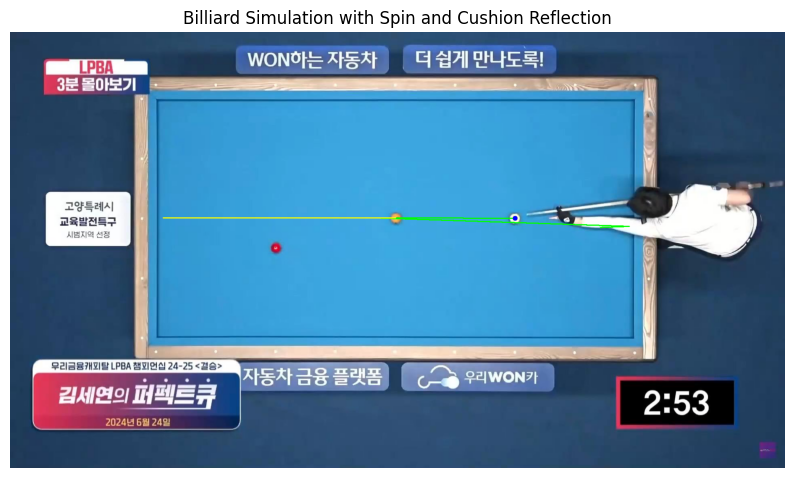

In [16]:
import pymunk
from pymunk import Vec2d
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

def to_cpu_float(value):
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
yellow_ball = next(obj for obj in objects if obj["cls_name"] == "yellow ball")
red_ball = next(obj for obj in objects if obj["cls_name"] == "red ball")

wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])

yx1, yy1 = to_cpu_float(yellow_ball["x1"]), to_cpu_float(yellow_ball["y1"])
yx2, yy2 = to_cpu_float(yellow_ball["x2"]), to_cpu_float(yellow_ball["y2"])

rx1, ry1 = to_cpu_float(red_ball["x1"]), to_cpu_float(red_ball["y1"])
rx2, ry2 = to_cpu_float(red_ball["x2"]), to_cpu_float(red_ball["y2"])

white_center_px = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
yellow_center_px = np.array([(yx1 + yx2) / 2.0, (yy1 + yy2) / 2.0])
red_center_px = np.array([(rx1 + rx2) / 2.0, (ry1 + ry2) / 2.0])

table_min_x = to_cpu_float(table["x1"])
table_min_y = to_cpu_float(table["y1"])
table_max_x = to_cpu_float(table["x2"])
table_max_y = to_cpu_float(table["y2"])

PIXELS_TO_METERS = 100.0

white_pos_world = (white_center_px / PIXELS_TO_METERS).tolist()
yellow_pos_world = (yellow_center_px / PIXELS_TO_METERS).tolist()
red_pos_world = (red_center_px / PIXELS_TO_METERS).tolist()

table_min_x_world = table_min_x / PIXELS_TO_METERS
table_min_y_world = table_min_y / PIXELS_TO_METERS
table_max_x_world = table_max_x / PIXELS_TO_METERS
table_max_y_world = table_max_y / PIXELS_TO_METERS

space = pymunk.Space()
space.gravity = (0, 0)

mass = 1.0
radius = 0.05
moment = pymunk.moment_for_circle(mass, 0, radius)

left = table_min_x_world + radius
right = table_max_x_world - radius
bottom = table_min_y_world + radius
top = table_max_y_world - radius

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top), (right, top), cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top), cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom), (right, top), cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.95
    c.friction = 0.01
    space.add(c)

white_body = pymunk.Body(mass, moment)
white_body.position = white_pos_world
white_body.angular_damping = 0.1
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.95
white_shape.friction = 0.02
white_shape.collision_type = 1
space.add(white_body, white_shape)

yellow_body = pymunk.Body(mass, moment)
yellow_body.position = yellow_pos_world
yellow_body.angular_damping = 0.1
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.95
yellow_shape.friction = 0.02
yellow_shape.collision_type = 3
space.add(yellow_body, yellow_shape)

red_body = pymunk.Body(mass, moment)
red_body.position = red_pos_world
red_body.angular_damping = 0.1
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.95
red_shape.friction = 0.02
red_shape.collision_type = 2
space.add(red_body, red_shape)

def collision_post_solve(arbiter, space, data):
    return True

for ctypeA, ctypeB in [(1, 3), (1, 2), (3, 2)]:
    handler = space.add_collision_handler(ctypeA, ctypeB)
    handler.post_solve = collision_post_solve

strength_gauge = 6
max_speed = 1.0
initial_speed = (strength_gauge / 10.0) * max_speed

base_vec = (yellow_body.position - white_body.position).normalized()
impact_offset_world = Vec2d(0.03, 0.0)
impact_point_world = white_body.position + impact_offset_world
impulse_magnitude = initial_speed * mass
impulse_vec = base_vec * impulse_magnitude
white_body.apply_impulse_at_world_point(impulse_vec, impact_point_world)

impact_point_px = impact_point_world * PIXELS_TO_METERS

dt = 1 / 60.0
max_steps = 3000
stop_threshold = 0.02
positions_white = []
positions_yellow = []
positions_red = []
global_friction_coef = 0.01

for step in range(max_steps):
    space.step(dt)

    white_body.velocity *= (1 - global_friction_coef * dt)
    yellow_body.velocity *= (1 - global_friction_coef * dt)
    red_body.velocity *= (1 - global_friction_coef * dt)

    if white_body.velocity.length < stop_threshold:
        white_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < stop_threshold:
        yellow_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < stop_threshold:
        red_body.velocity = Vec2d(0, 0)

    positions_white.append((white_body.position.x, white_body.position.y))
    positions_yellow.append((yellow_body.position.x, yellow_body.position.y))
    positions_red.append((red_body.position.x, red_body.position.y))

    if (
        white_body.velocity.length == 0
        and yellow_body.velocity.length == 0
        and red_body.velocity.length == 0
    ):
        break

image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Could not load image: {image_path}")

def draw_trajectory(img, positions, color_bgr):
    for i in range(len(positions) - 1):
        x1, y1 = positions[i]
        x2, y2 = positions[i + 1]
        pt1 = (int(x1 * PIXELS_TO_METERS), int(y1 * PIXELS_TO_METERS))
        pt2 = (int(x2 * PIXELS_TO_METERS), int(y2 * PIXELS_TO_METERS))
        cv2.line(img, pt1, pt2, color_bgr, 2)

draw_trajectory(image, positions_white, (0, 255, 0))
draw_trajectory(image, positions_yellow, (0, 255, 255))
draw_trajectory(image, positions_red, (0, 0, 255))

impact_pt_int = (int(impact_point_px.x), int(impact_point_px.y))
cv2.circle(image, impact_pt_int, 6, (255, 0, 0), -1)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Billiard Simulation with Spin and Cushion Reflection")
plt.show()


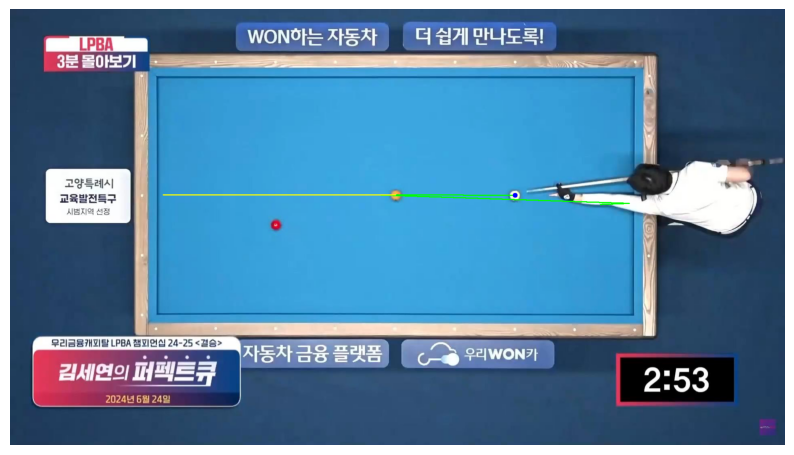

In [17]:
import pymunk
from pymunk import Vec2d
import numpy as np
import cv2
import matplotlib.pyplot as plt

def to_cpu_float(value):
    if isinstance(value, torch.Tensor):
        return float(value.detach().cpu().item())
    return float(value)

white_ball = next(obj for obj in objects if obj["cls_name"] == "white ball")
yellow_ball = next(obj for obj in objects if obj["cls_name"] == "yellow ball")
red_ball = next(obj for obj in objects if obj["cls_name"] == "red ball")

wx1, wy1 = to_cpu_float(white_ball["x1"]), to_cpu_float(white_ball["y1"])
wx2, wy2 = to_cpu_float(white_ball["x2"]), to_cpu_float(white_ball["y2"])

yx1, yy1 = to_cpu_float(yellow_ball["x1"]), to_cpu_float(yellow_ball["y1"])
yx2, yy2 = to_cpu_float(yellow_ball["x2"]), to_cpu_float(yellow_ball["y2"])

rx1, ry1 = to_cpu_float(red_ball["x1"]), to_cpu_float(red_ball["y1"])
rx2, ry2 = to_cpu_float(red_ball["x2"]), to_cpu_float(red_ball["y2"])

white_center_px = np.array([(wx1 + wx2) / 2.0, (wy1 + wy2) / 2.0])
yellow_center_px = np.array([(yx1 + yx2) / 2.0, (yy1 + yy2) / 2.0])
red_center_px = np.array([(rx1 + rx2) / 2.0, (ry1 + ry2) / 2.0])

table_min_x = to_cpu_float(table["x1"])
table_min_y = to_cpu_float(table["y1"])
table_max_x = to_cpu_float(table["x2"])
table_max_y = to_cpu_float(table["y2"])

PIXELS_TO_METERS = 100.0

white_pos_world = (white_center_px / PIXELS_TO_METERS).tolist()
yellow_pos_world = (yellow_center_px / PIXELS_TO_METERS).tolist()
red_pos_world = (red_center_px / PIXELS_TO_METERS).tolist()

table_min_x_world = table_min_x / PIXELS_TO_METERS
table_min_y_world = table_min_y / PIXELS_TO_METERS
table_max_x_world = table_max_x / PIXELS_TO_METERS
table_max_y_world = table_max_y / PIXELS_TO_METERS

space = pymunk.Space()
space.gravity = (0, 0)

mass = 1.0
radius = 0.05
moment = pymunk.moment_for_circle(mass, 0, radius)

left = table_min_x_world + radius
right = table_max_x_world - radius
bottom = table_min_y_world + radius
top = table_max_y_world - radius

cushion_thickness = 0.01
cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), cushion_thickness),
    pymunk.Segment(space.static_body, (left, top), (right, top), cushion_thickness),
    pymunk.Segment(space.static_body, (left, bottom), (left, top), cushion_thickness),
    pymunk.Segment(space.static_body, (right, bottom), (right, top), cushion_thickness),
]
for c in cushions:
    c.elasticity = 0.95
    c.friction = 0.01
    space.add(c)

white_body = pymunk.Body(mass, moment)
white_body.position = white_pos_world
white_body.angular_damping = 0.1
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.95
white_shape.friction = 0.02
white_shape.collision_type = 1
space.add(white_body, white_shape)

yellow_body = pymunk.Body(mass, moment)
yellow_body.position = yellow_pos_world
yellow_body.angular_damping = 0.1
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.95
yellow_shape.friction = 0.02
yellow_shape.collision_type = 3
space.add(yellow_body, yellow_shape)

red_body = pymunk.Body(mass, moment)
red_body.position = red_pos_world
red_body.angular_damping = 0.1
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.95
red_shape.friction = 0.02
red_shape.collision_type = 2
space.add(red_body, red_shape)

def collision_post_solve(arbiter, space, data):
    sA, sB = arbiter.shapes
    return True

for ctypeA, ctypeB in [(1, 3), (1, 2), (3, 2)]:
    h = space.add_collision_handler(ctypeA, ctypeB)
    h.post_solve = collision_post_solve

strength_gauge = 6
max_speed = 1.0
initial_speed = (strength_gauge / 10.0) * max_speed

base_vec = (yellow_body.position - white_body.position).normalized()

impact_offset_world = Vec2d(0.03, 0.0)
impact_point_world = white_body.position + impact_offset_world

impulse_magnitude = initial_speed * mass
impulse_vec = base_vec * impulse_magnitude
white_body.apply_impulse_at_world_point(impulse_vec, impact_point_world)

impact_point_px = impact_point_world * PIXELS_TO_METERS

dt = 1 / 60.0
max_steps = 3000
stop_threshold = 0.02

positions_white = []
positions_yellow = []
positions_red = []

wall_hit_count = 0

global_friction_coef = 0.01

for step in range(max_steps):
    space.step(dt)

    white_body.velocity *= (1 - global_friction_coef * dt)
    yellow_body.velocity *= (1 - global_friction_coef * dt)
    red_body.velocity *= (1 - global_friction_coef * dt)

    if white_body.velocity.length < stop_threshold:
        white_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < stop_threshold:
        yellow_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < stop_threshold:
        red_body.velocity = Vec2d(0, 0)

    positions_white.append((white_body.position.x, white_body.position.y))
    positions_yellow.append((yellow_body.position.x, yellow_body.position.y))
    positions_red.append((red_body.position.x, red_body.position.y))

    if (white_body.velocity.length == 0 and
            yellow_body.velocity.length == 0 and
            red_body.velocity.length == 0):
        break

image = cv2.imread(image_path)

def draw_trajectory(img, positions, color_bgr):
    for i in range(len(positions) - 1):
        x1, y1 = positions[i]
        x2, y2 = positions[i + 1]
        pt1 = (int(x1 * PIXELS_TO_METERS), int(y1 * PIXELS_TO_METERS))
        pt2 = (int(x2 * PIXELS_TO_METERS), int(y2 * PIXELS_TO_METERS))
        cv2.line(img, pt1, pt2, color_bgr, 2)

draw_trajectory(image, positions_white, (0, 255, 0))
draw_trajectory(image, positions_yellow, (0, 255, 255))
draw_trajectory(image, positions_red, (0, 0, 255))

impact_pt_int = (int(impact_point_px.x), int(impact_point_px.y))
cv2.circle(image, impact_pt_int, 6, (255, 0, 0), -1)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


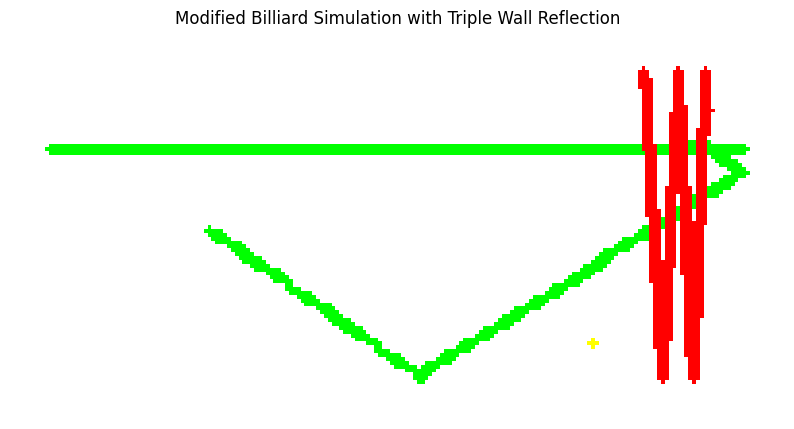

In [18]:
import pymunk
from pymunk import Vec2d
import numpy as np
import cv2
import matplotlib.pyplot as plt

PIXELS_TO_METERS = 100.0
def to_world_pos(pixels):
    return [coord / PIXELS_TO_METERS for coord in pixels]

space = pymunk.Space()
space.gravity = (0, 0)

mass = 1.0
radius = 0.05
moment = pymunk.moment_for_circle(mass, 0, radius)

bounds = [0, 0, 2, 1]
left, bottom, right, top = bounds[0] + radius, bounds[1] + radius, bounds[2] - radius, bounds[3] - radius

cushions = [
    pymunk.Segment(space.static_body, (left, bottom), (right, bottom), 0.01),
    pymunk.Segment(space.static_body, (left, top), (right, top), 0.01),
    pymunk.Segment(space.static_body, (left, bottom), (left, top), 0.01),
    pymunk.Segment(space.static_body, (right, bottom), (right, top), 0.01),
]
for c in cushions:
    c.elasticity = 0.95
    space.add(c)

white_body = pymunk.Body(mass, moment)
white_body.position = Vec2d(0.5, 0.5)
white_shape = pymunk.Circle(white_body, radius)
white_shape.elasticity = 0.95
space.add(white_body, white_shape)

yellow_body = pymunk.Body(mass, moment)
yellow_body.position = Vec2d(1.5, 0.8)
yellow_shape = pymunk.Circle(yellow_body, radius)
yellow_shape.elasticity = 0.95
space.add(yellow_body, yellow_shape)

red_body = pymunk.Body(mass, moment)
red_body.position = Vec2d(1.8, 0.2)
red_shape = pymunk.Circle(red_body, radius)
red_shape.elasticity = 0.95
space.add(red_body, red_shape)

initial_speed = 1.2
angle = np.radians(35)
impulse_vec = Vec2d(np.cos(angle), np.sin(angle)) * initial_speed * mass
white_body.apply_impulse_at_world_point(impulse_vec, white_body.position + Vec2d(0.03, 0.02))

dt = 1 / 60.0
positions_white = []
positions_yellow = []
positions_red = []

for step in range(500):
    space.step(dt)

    if white_body.velocity.length < 0.01:
        white_body.velocity = Vec2d(0, 0)
    if yellow_body.velocity.length < 0.01:
        yellow_body.velocity = Vec2d(0, 0)
    if red_body.velocity.length < 0.01:
        red_body.velocity = Vec2d(0, 0)

    positions_white.append((white_body.position.x, white_body.position.y))
    positions_yellow.append((yellow_body.position.x, yellow_body.position.y))
    positions_red.append((red_body.position.x, red_body.position.y))

image = np.ones((int(bounds[3] * PIXELS_TO_METERS), int(bounds[2] * PIXELS_TO_METERS), 3), dtype=np.uint8) * 255

def draw_trajectory(img, positions, color):
    for i in range(len(positions) - 1):
        pt1 = tuple((np.array(positions[i]) * PIXELS_TO_METERS).astype(int))
        pt2 = tuple((np.array(positions[i + 1]) * PIXELS_TO_METERS).astype(int))
        cv2.line(img, pt1, pt2, color, 2)

draw_trajectory(image, positions_white, (0, 255, 0))
draw_trajectory(image, positions_yellow, (0, 255, 255))
draw_trajectory(image, positions_red, (0, 0, 255))

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Modified Billiard Simulation with Triple Wall Reflection")
plt.show()
